In [1]:
import glob
import os
import re
import random
import numpy as np
import pandas as pd
import math
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
os.chdir("D://Datasets")

In [3]:
corpus = []

for path in Path('All enron unzip').rglob('*.txt'):
        with open(path, errors='ignore') as f_input:
            corpus.append(f_input.read())

In [4]:
df = pd.DataFrame(corpus)
df.head()

,0
0,Legitimate\n----------\n- Owner: farmer-d\n- T...
1,Subject: christmas tree farm pictures\n
2,"Subject: vastar resources , inc .\ngary , prod..."
3,Subject: calpine daily gas nomination\n- calpi...
4,Subject: re : issue\nfyi - see note below - al...


In [5]:
len(df)

27721

In [6]:
df = df.drop([0,5173,11031,16544,21720]) # Removed the summary bits
df.columns=["E-mails"]

In [7]:
df = df.sample(frac=1)	# Shuffle the entire dataframe
ten_off_df = math.floor(len(df)/10)

In [8]:
#################[Failed FOR loop attempt]
# df_temp = df
# for i in range(1,9):
 #    locals()['df_{}.index.values'.format(i)] = df_temp.sample(ten_off_df)
 #    c_df = locals()['df_{}'.format(i)]
 #    locals()['l_{}'.format(i)] = list(c_df.index.values)
 #    loc_l = locals()['l_{}'.format(i)]
 #    df_temp = df_temp.drop(loc_l)

In [9]:
################# [Good For loop attempt]
df_temp = df
random.seed(a=5)
for i in range(0,9):
    a = df_temp.sample(ten_off_df)
    locals()['df_{}'.format(i)] = a
    l = list(a.index.values)
    df_temp = df_temp.drop(l)

In [10]:
df_test = df_temp

frames=[df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]
df_train = pd.concat(frames)

In [11]:
len(df_train)+len(df_test)==len(df)	## Check if the split was properly done

True

In [12]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\axl_a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
df_test

,E-mails
5558,Subject: re : aiesec polska - eurolds 2000\ndr...
3248,Subject: cleburne imbalance\ndaren - -\nbad ne...
14565,Subject: re :\nhi louise .\nthis spreadsheet h...
9494,Subject: schedule and more . .\ndr . kaminski ...
17538,Subject: request submitted : access request fo...
...,...
27027,Subject: notice : congrats . you have been acc...
4991,"Subject: re : oem photoshop , photoshop , font..."
12386,Subject: trading systems workshop .\nwe will b...
9865,Subject: urgent assistance ( confidential )\nd...


In [14]:
df_train

,E-mails
18489,Subject: re : doctor approved pill lgw\na man ...
20145,Subject: you don _ t know how to attract custo...
5857,Subject: last minute things\ntff participants ...
23861,Subject: arturo how could you do this ?\ntake ...
24469,Subject: anal s 3 x\nplease let\nthe image loa...
...,...
6420,Subject: re : visit to houston and vince kamin...
2505,"Subject: enron / hpl actuals for january 30 , ..."
22159,Subject: re : migration request\ni have replac...
3591,Subject: welcome to aol instant messenger !\nw...


In [15]:
l1 = stopwords.words('english')
lst1 = [' {} '.format(x) for x in l1]
lst1.append('Subject:')
lst1.append('Subject :')
lst1.remove(' re ')
# lst2 = [ '.{} '.format(x) for x in l1]
# lst3 = [ ' {}.'.format(x) for x in l1]

In [16]:
# Remove too common words from the list we procurred:
for i in range(0,9):
    locals()['df_{}'.format(i)]['E-mails'].replace(lst1, " ", regex=True, inplace=True)
   #  locals()['df_{}'.format(i)]['E-mails'].replace(lst2, " ", regex=True, inplace=True)
   #  locals()['df_{}'.format(i)]['E-mails'].replace(lst3, " ", regex=True, inplace=True)
df_train['E-mails'].replace(lst1, " ", regex=True, inplace=True)
df_test['E-mails'].replace(lst1, " ", regex=True, inplace=True)

In [17]:
# Remove punctuation and often used symbols, but NOT ':' since we'll need later
# "[?!.,;()\/|]"
for i in range(0,9):
    locals()['df_{}'.format(i)]['E-mails'].replace('[?!.,;()\/|]', " ", regex=True, inplace=True)
df_train['E-mails'].replace('[?!.,;()\/|]', " ", regex=True, inplace=True)
df_test['E-mails'].replace('[?!.,;()\/|]', " ", regex=True, inplace=True)

In [18]:
df_train

,E-mails
18489,re : doctor approved pill lgw\na man endowed...
20145,_ know attract customers website \nsubmitti...
5857,last minute things\ntff participants \nwe l...
23861,arturo could \ntake next level \nfill ...
24469,anal 3 x\nplease let\nthe image load \n...
...,...
6420,re : visit houston vince kaminski ' research...
2505,enron hpl actuals january 30 2001\nteco ...
22159,re : migration request\ni replace old basis ...
3591,welcome aol instant messenger \nwelcome aol...


In [19]:
df_test

,E-mails
5558,re : aiesec polska - eurolds 2000\ndrogi pan...
3248,cleburne imbalance\ndaren - -\nbad news ...
14565,re :\nhi louise \nthis spreadsheet life - -...
9494,schedule \ndr kaminski \ni think ' abl...
17538,request submitted : access request dan har...
...,...
27027,notice : congrats accepted\nwe tried conta...
4991,re : oem photoshop photoshop font - size...
12386,trading systems workshop \nwe holding tradi...
9865,urgent assistance confidential \ndear sir...


In [20]:
df_4

,E-mails
23839,winning notification congratulation \nfro...
10331,commercialization nasa technology\nhey tho...
8411,re : durasoft - - java class\nwhat think opt...
23855,cheap vicodin online - fda pharm \nprescrip...
18074,xxx site passwords\nstop\npaying porn\nyou w...
...,...
1910,enron hpl actuals october 24 2000\nteco ...
20186,"perfect logo charset = koi 8 - r "" >\nthinki..."
25581,' \nand good morning : \nsau bul\n
8886,re : astros season tickets\ncathy \nthanks ...


In [21]:
df_0_ok = df_0[df_0['E-mails'].str.contains("re :") | df_0['E-mails'].str.contains("fw :")]
df_1_ok = df_1[df_1['E-mails'].str.contains("re :") | df_1['E-mails'].str.contains("fw :")]
df_2_ok = df_2[df_2['E-mails'].str.contains("re :") | df_2['E-mails'].str.contains("fw :")]
df_3_ok = df_3[df_3['E-mails'].str.contains("re :") | df_3['E-mails'].str.contains("fw :")]
df_4_ok = df_4[df_4['E-mails'].str.contains("re :") | df_4['E-mails'].str.contains("fw :")]
df_5_ok = df_5[df_5['E-mails'].str.contains("re :") | df_5['E-mails'].str.contains("fw :")]
df_6_ok = df_6[df_6['E-mails'].str.contains("re :") | df_6['E-mails'].str.contains("fw :")]
df_7_ok = df_7[df_7['E-mails'].str.contains("re :") | df_7['E-mails'].str.contains("fw :")]
df_8_ok = df_8[df_8['E-mails'].str.contains("re :") | df_8['E-mails'].str.contains("fw :")]
df_train_ok = df_train[df_train['E-mails'].str.contains("re :") | df_train['E-mails'].str.contains("fw :")]

In [22]:
df_0_ok

,E-mails
18489,re : doctor approved pill lgw\na man endowed...
7790,re : update event time change\nthis fine -...
9067,re : prc feedback forms\ngina \ni shall gla...
8648,fw : mckinsey partner specializing agricultu...
13344,re :\ncalling error unfair prepared offer ...
...,...
6400,re : hello\nshijie \nthanks message assis...
5963,re : confirm participation real options conf...
1283,re : august spot tickets\nvance \ndeal # 34...
9955,re : favorite programs incredibly low prices...


In [23]:
for i in range(0,9):
    locals()['y_{}'.format(i)] = np.array([len(locals()['df_{}_ok'.format(i)]), len(locals()['df_{}'.format(i)]) - len(locals()['df_{}_ok'.format(i)])])

y=np.array([len(df_train_ok), len(df_train)-len(df_train_ok)])

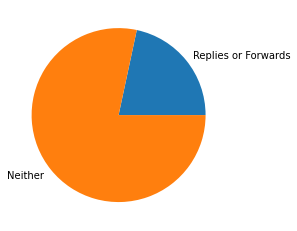

In [24]:
plt.pie(y, labels=["Replies or Forwards", "Neither"])
plt.show()

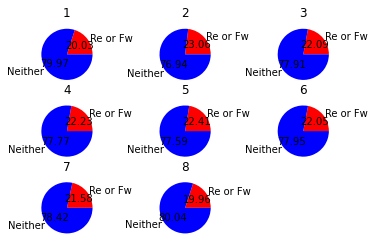

In [25]:
for i in range(1,9):
    plt.subplot(3,3,i)
    plt.pie(locals()['y_{}'.format(i)], labels=["Re or Fw", "Neither"], autopct = '%.2f', colors = ['red', 'blue']) 
    plt.title('{}'.format(i))
    
plt.show()    